In [1]:
# Load in the packages
import numpy as np
import folktables
from folktables import ACSDataSource, ACSIncome

import os
import sys
import copy
sys.path.append('..')
import random
import FairCertModule
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
from FullyConnected import FullyConnected
import pytorch_lightning as pl

# Set random seeds
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
dataset = "Folk"
from sklearn.decomposition import PCA

def project_onto_2d_pca(data, data2):
    """
    Given a 2D array of shape (N, D), where N is the number of points and D is the number of dimensions,
    use sklearn PCA to project the data onto its two principal components, and return a 2D array of shape (N, 2).
    """
    pca = PCA(n_components=2)
    projected_data = pca.fit_transform(data)
    projected_data2 = pca.transform(data2)
    return projected_data, projected_data2



In [2]:
import folk_utils
a, b, c, y_1, _, _, _, _ = folk_utils.get_dataset(dataset)
X1 = np.concatenate((a,b,c))
a, b, c, y_2, _, _, _, _ = folk_utils.get_dataset(dataset, state="NY")
X2 = np.concatenate((a,b,c))
print(X1.shape)
print(X2.shape)

/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


(187475, 42)
(100866, 42)


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


In [3]:
from tqdm import tqdm

def compute_transport_cost(X1, X2):
    cost_values = []
    for x in X2[0:1000]:
        v = np.linalg.norm(x-X1, ord=np.inf, axis=1)
        #v = np.linalg.norm(x-X1, ord=2, axis=1)
        cost_values.append(min(v))
        #print(v.shape)
    return np.mean(cost_values)
#compute_transport_cost(X1, X2)

In [4]:
from tqdm import trange, tqdm
states = ["AL", "AZ", "AR", "CO", "CT", "DE", "FL", "GA", 
      "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
      "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ"] 
 #     "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
 #     "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
folk_values = []
cove_values = []
empl_values = []

dataset = "Folk"
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for state in tqdm(states):  
    try:
        a, b, c, _, _, _, _, _ = folk_utils.get_dataset(dataset, state=state, scaler=scale)
        X2 = np.concatenate((a,b,c))
        val = compute_transport_cost(X1, X2)
        print(val)
        folk_values.append(val)
    except:
        continue
        
dataset = "Coverage"     
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for state in tqdm(states):  
    try:
        a, b, c, _, _, _, _, _ = folk_utils.get_dataset(dataset, state=state)
        X2 = np.concatenate((a,b,c))
        val = compute_transport_cost(X1, X2)
        cove_values.append(val)
    except:
        continue
        
dataset = "Employ" 
empl_values = []
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for state in tqdm(states):  
    try:
        a, b, c, _, _, _, _, _ = folk_utils.get_dataset(dataset, state=state, scaler=scale)
        X2 = np.concatenate((a,b,c))
        val = compute_transport_cost(X1, X2)
        empl_values.append(val)
    except:
        continue

/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
  0%|                                                                                                                                  | 0/28 [00:00<?, ?it/s]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp

0.22404757


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
  7%|████████▋                                                                                                                 | 2/28 [00:42<09:06, 21.04s/it]

0.23952699


 11%|█████████████                                                                                                             | 3/28 [00:42<04:50, 11.63s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 14%|█████████████████▍                                                                                                        | 4/28 [01:03<06:08, 15.34s/it]

0.21970227


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 21%|██████████████████████████▏                                                                                               | 6/28 [01:24<04:13, 11.53s/it]

0.22909331


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 25%|██████████████████████████████▌                                                                                           | 7/28 [01:48<05:29, 15.68s/it]

0.2569483


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 29%|██████████████████████████████████▊                                                                                       | 8/28 [02:11<05:59, 17.96s/it]

0.2368093


 36%|███████████████████████████████████████████▏                                                                             | 10/28 [02:12<02:35,  8.66s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 39%|███████████████████████████████████████████████▌                                                                         | 11/28 [02:34<03:40, 12.96s/it]

0.230954


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 43%|███████████████████████████████████████████████████▊                                                                     | 12/28 [02:56<04:08, 15.52s/it]

0.2138236


 46%|████████████████████████████████████████████████████████▏                                                                | 13/28 [02:56<02:44, 10.96s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 50%|████████████████████████████████████████████████████████████▌                                                            | 14/28 [03:17<03:15, 13.94s/it]

0.23764773


 54%|████████████████████████████████████████████████████████████████▊                                                        | 15/28 [03:18<02:09,  9.94s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 57%|█████████████████████████████████████████████████████████████████████▏                                                   | 16/28 [03:39<02:39, 13.31s/it]

0.25013703


 61%|█████████████████████████████████████████████████████████████████████████▍                                               | 17/28 [03:39<01:43,  9.37s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 64%|█████████████████████████████████████████████████████████████████████████████▊                                           | 18/28 [04:00<02:09, 12.97s/it]

0.2631805


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 68%|██████████████████████████████████████████████████████████████████████████████████                                       | 19/28 [04:22<02:19, 15.54s/it]

0.23871906


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 71%|██████████████████████████████████████████████████████████████████████████████████████▍                                  | 20/28 [04:44<02:20, 17.56s/it]

0.22333792


 79%|███████████████████████████████████████████████████████████████████████████████████████████████                          | 22/28 [04:45<00:53,  8.90s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 24/28 [05:07<00:35,  8.91s/it]

0.22472408


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 25/28 [05:07<00:18,  6.32s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 26/28 [05:28<00:21, 10.64s/it]

0.23912011


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 27/28 [05:28<00:07,  7.51s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [05:50<00:00, 12.52s/it]

0.24534452



/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
  0%|                                                                                                                                  | 0/28 [00:00<?, ?it/s]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/a

 36%|███████████████████████████████████████████▏                                                                             | 10/28 [01:49<02:04,  6.93s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 39%|███████████████████████████████████████████████▌                                                                         | 11/28 [02:08<02:59, 10.55s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 21/28 [04:30<01:18, 11.27s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 79%|███████████████████████████████████████████████████████████████████████████████████████████████                          | 22/28 [04:47<01:18, 13.09s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python

 21%|██████████████████████████▏                                                                                               | 6/28 [04:07<15:06, 41.21s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 25%|██████████████████████████████▌                                                                                           | 7/28 [04:52<14:45, 42.17s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 29%|██████████████████████████████████▊                                                                                       | 8/28 [05:34<14:03, 42.18s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/li

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 27/28 [18:35<00:40, 40.70s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [19:18<00:00, 41.36s/it]


In [5]:
print(folk_values)
print(cove_values)
print(empl_values)

folk_geog = copy.deepcopy(folk_values)
cove_geog = copy.deepcopy(cove_values)
empl_geog = copy.deepcopy(empl_values)
#folk_values = [0.25144866, 0.2752958, 0.25109202, 0.25915453, 0.29310367, 0.26922002, 0.26454285, 0.24255718, 0.2701151, 0.28311193, 0.29835808, 0.27295247, 0.25499606, 0.25626612, 0.27694494, 0.27391657, 0.30466267, 0.3107429, 0.28384626, 0.2832968, 0.29679802, 0.27908525, 0.28664467, 0.30785552, 0.28896448, 0.30004743, 0.29911387, 0.31197762, 0.30623767]
#cove_values = [0.776879, 0.49305093, 0.7956254, 0.49845916, 0.39307556, 0.55277, 0.4711712, 0.7214991, 0.66407007, 0.63435847, 0.81702936, 0.7206375, 0.45034066, 0.45234045, 0.70726377, 0.76955104, 0.72776437, 0.44950813, 0.31369805, 0.3360746, 0.6257373, 0.710198, 0.7462397, 0.63469, 0.65785635, 0.7047733, 0.70834976, 0.39269078, 0.5494169, 0.52230287, 0.91089416, 0.66420865]
#empl_values = [0.09654577, 0.0959295, 0.13311733, 0.06833401, 0.08530241, 0.083176926, 0.11203137, 0.09811043, 0.104559146, 0.0947853, 0.07569979, 0.088849835, 0.06572623, 0.08185196, 0.10499661, 0.1041375, 0.109878324, 0.086432844, 0.09271454, 0.07629319, 0.07708767, 0.122410536, 0.094766065, 0.086647905, 0.06824387, 0.11679827, 0.08031518, 0.079719365, 0.091189526, 0.08414438, 0.09069528, 0.07361586, 0.08860324, 0.10129971, 0.10542116, 0.08910539, 0.097106576, 0.08395821, 0.06699185, 0.103676856, 0.07738371, 0.06587194, 0.08426589, 0.084403, 0.09326754, 0.117055796, 0.062078103, 0.0852813]

#cove_values = [0.776879, 0.49305093, 0.7956254, 0.49845916, 0.39307556, 0.55277, 0.4711712, 0.7214991, 0.66407007, 0.63435847, 0.81702936, 0.7206375, 0.45034066, 0.45234045, 0.70726377, 0.76955104, 0.72776437, 0.44950813, 0.31369805]
cove_values = np.asarray(cove_values)/2.0


[0.22404757, 0.23952699, 0.21970227, 0.22909331, 0.2569483, 0.2368093, 0.230954, 0.2138236, 0.23764773, 0.25013703, 0.2631805, 0.23871906, 0.22333792, 0.22472408, 0.23912011, 0.24534452]
[0.776879, 0.49305093, 0.7956254, 0.49845916, 0.39307556, 0.55277, 0.4711712, 0.7214991, 0.66407007, 0.63435847, 0.81702936, 0.7206375, 0.45034066, 0.45234045, 0.70726377, 0.76955104, 0.72776437, 0.44950813, 0.31369805]
[0.078738555, 0.07502243, 0.10771164, 0.052763376, 0.06437316, 0.06718753, 0.09445817, 0.078356385, 0.08539535, 0.068798676, 0.055995833, 0.074428834, 0.048948932, 0.06471772, 0.07874699, 0.08161025, 0.08554559, 0.06377873, 0.07508154, 0.06117273, 0.056761254, 0.09156563, 0.07656574, 0.070144475, 0.053586956, 0.092692524, 0.063081525, 0.061174326]


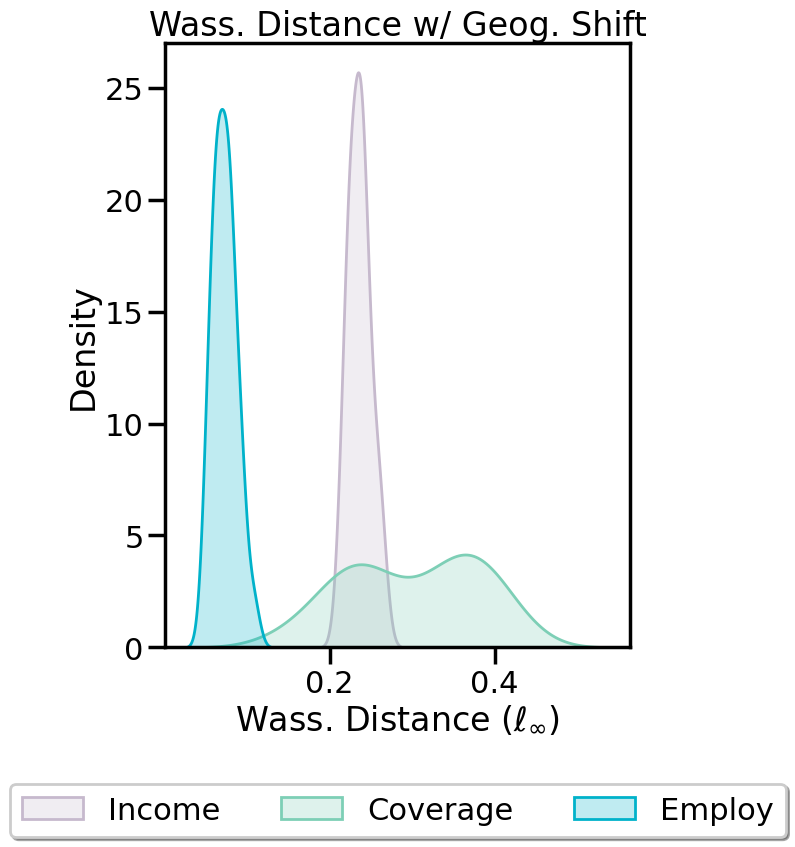

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(6,8), dpi=100)
sns.kdeplot(np.asarray(folk_values)/1, fill=True, color="#C6B9CD", label="Income")
sns.kdeplot(np.asarray(cove_values)/1, fill=True, color="#7DCFB6", label="Coverage")
sns.kdeplot(np.asarray(empl_values)/1, fill=True, color="#00B2CA", label="Employ")
#plt.axvline(x=0.26522, c='k', linestyle="--")
#plt.text(0.253,12,'0.04',rotation=90,fontsize=24)
#plt.axvline(x=0.32403, c='k', linestyle="--")
#plt.text(0.313,12,'0.05',rotation=90,fontsize=24)
#plt.axvline(x=0.38884, c='k', linestyle="--")
#plt.text(0.378,12,'0.06',rotation=90,fontsize=24)
#plt.xlim((0.22, 0.4))
plt.title("Wass. Distance w/ Geog. Shift")
plt.xlabel(r"Wass. Distance ($\ell_\infty$)")
# Put a legend below current axis
ax=plt.gca()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [ ]:
# Now we compute E-DIF distribution and our bounds!

MODEL_STATE  = 'CA'
MODEL_YEAR   = '2015'
MODEL_WIDTH  = '256'
MODEL_METRIC = 'LP'

sgd_id = "SGD" 
pgd_id = "FAIR-PGD" 
ibp_id = "FAIR-IBP" 
glob_id = "FAIR-DRO"
ibpg_id = "FAIR-IBPG"

def load_model_from_id(model_id, dataset, width=MODEL_WIDTH):
    model = FullyConnected(hidden_lay=2, hidden_dim=256, dataset=dataset)
    ckpt = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    checkpoint = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    model.load_state_dict(torch.load('%sModels/%s.pt'%(dataset, model_id)))
    return model

#sgd_model = load_model_from_id(sgd_id, dataset)
#pgd_model = load_model_from_id(pgd_id, dataset)
#ibp_model = load_model_from_id(ibp_id, dataset)
#glob_model = load_model_from_id(glob_id, dataset)
#ibpg_model = load_model_from_id(ibpg_id, dataset)


In [ ]:
from folk_utils import I
#years = ["2015", "2016", "2017", "2018", "2019"]
folk_values = []
cove_values = []
empl_values = []

ID = ibpg_id

dataset = "Folk"
model = load_model_from_id(ID, dataset)
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for state in tqdm(states):  
    try:
        a, b, c, d, e, f, lp_epsilon, _ = folk_utils.get_dataset(dataset, state=state, scaler=scale)
        X2 = np.concatenate((a,b,c))
        Y2 = np.concatenate((d,e,f))
        val = torch.mean(I(model, torch.Tensor(X2), torch.Tensor(Y2).long(), lp_epsilon, 0.05, 2))
        folk_values.append(float(val.detach()))
        print(val.detach())
    except:
        continue
        
dataset = "Coverage"
model = load_model_from_id(ID, dataset)
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for state in tqdm(states):  
    try:
        a, b, c, d, e, f, lp_epsilon, _ = folk_utils.get_dataset(dataset, state=state)
        X2 = np.concatenate((a,b,c))
        Y2 = np.concatenate((d,e,f))
        val = torch.mean(I(model, torch.Tensor(X2), torch.Tensor(Y2).long(), lp_epsilon, 0.05, 2))
        cove_values.append(float(val.detach()))
        print(val.detach())
    except:
        continue
        
dataset = "Employ"
model = load_model_from_id(ID, dataset)
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for state in tqdm(states):  
    try:
        a, b, c, d, e, f, lp_epsilon, _ = folk_utils.get_dataset(dataset, state=state, scaler=scale)
        X2 = np.concatenate((a,b,c))
        Y2 = np.concatenate((d,e,f))
        val = torch.mean(I(model, torch.Tensor(X2), torch.Tensor(Y2).long(), lp_epsilon, 0.05, 2))
        empl_values.append(float(val.detach()))
        print(val.detach())
    except:
        continue
        

In [ ]:
from folk_utils import compute_DIF_certification, compute_DIF_falsification

dataset = "Folk"
model = load_model_from_id(ID, dataset)
a, b, c, d, e, f, lp_epsilon, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X = torch.Tensor(c)
Y = torch.Tensor(f)
folk_lower = compute_DIF_falsification(model, lp_epsilon, 0.15, 0.05, X, Y, N=1000, iters=500, rettrend=False)  
folk_upper = compute_DIF_certification(model, lp_epsilon, 0.15, 0.05, X, Y, N=1000, iters=500, lr=10.05, rettrend=False) 


dataset = "Coverage"
model = load_model_from_id(ID, dataset)
a, b, c, d, e, f, lp_epsilon, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X = torch.Tensor(c)
Y = torch.Tensor(f)
cove_lower = compute_DIF_falsification(model, lp_epsilon, 0.25, 0.05, X, Y, N=1000, iters=500, rettrend=False)  
cove_upper = compute_DIF_certification(model, lp_epsilon, 0.25, 0.05, X, Y, N=1000, iters=500, lr=0.5, rettrend=False) 


dataset = "Employ"
model = load_model_from_id(ID, dataset)
a, b, c, d, e, f, lp_epsilon, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X = torch.Tensor(c)
Y = torch.Tensor(f)
empl_lower = compute_DIF_falsification(model, lp_epsilon, 0.35, 0.05, X, Y, N=1000, iters=500, rettrend=False)  
empl_upper = compute_DIF_certification(model, lp_epsilon, 0.35, 0.05, X, Y, N=10000, iters=500, lr=50.5, rettrend=False) 


In [ ]:
print("hello")
dataset_name = []
value_column = []
for i in tqdm(folk_values):
    value_column.append(i)
    dataset_name.append("Folk")
for i in tqdm(cove_values):
    value_column.append(i)
    dataset_name.append("Coverage")
for i in tqdm(empl_values):
    value_column.append(i)
    dataset_name.append("Employ")
print("done")

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(6,8), dpi=100)

    
pal = ["#C6B9CD", "#7DCFB6", "#00B2CA"]
    
import pandas as pd

df = pd.DataFrame({'dataset':dataset_name, 'value':value_column})

sns.boxenplot(x="dataset", y="value", data=df, palette=pal, linewidth=0.5)
sns.stripplot(x="dataset", y="value", data=df, palette=pal, linewidth=0.5)

plt.scatter(x=[0], y=[folk_lower.detach()], marker=10, s=300, c="#4fb1d6", zorder=100)
plt.scatter(x=[0], y=[folk_upper], marker=11, s=300, c="#d64f4f", zorder=100)

plt.scatter(x=[1], y=[cove_lower.detach()], marker=10, s=300, c="#4fb1d6", zorder=100)
plt.scatter(x=[1], y=[cove_upper], marker=11, s=300, c="#d64f4f", zorder=100)

plt.scatter(x=[2], y=[empl_lower.detach()], marker=10, s=300, c="#4fb1d6", zorder=100)
plt.scatter(x=[2], y=[empl_upper/2], marker=11, s=300, c="#d64f4f", zorder=100)

plt.ylabel('DIF Violation')
plt.title('U-DRO Model')
plt.show()

In [ ]:
asdf = asdf

In [ ]:
years = ["2015", "2016", "2017", "2018", "2019"]
folk_values = []
cove_values = []
empl_values = []

dataset = "Folk"
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for year in tqdm(years):  
    try:
        a, b, c, _, _, _, _, _ = folk_utils.get_dataset(dataset, year=year, scaler=scale)
        X2 = np.concatenate((a,b,c))
        val = compute_transport_cost(X1, X2)
        folk_values.append(val)
    except:
        continue
        
dataset = "Coverage"     
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for year in tqdm(years):  
    try:
        a, b, c, _, _, _, _, _ = folk_utils.get_dataset(dataset, year=year)
        X2 = np.concatenate((a,b,c))
        val = compute_transport_cost(X1, X2)
        cove_values.append(val)
    except:
        continue
        
dataset = "Employ" 
empl_values = []
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for year in tqdm(years):  
    try:
        a, b, c, _, _, _, _, _ = folk_utils.get_dataset(dataset, year=year, scaler=scale)
        X2 = np.concatenate((a,b,c))
        val = compute_transport_cost(X1, X2)
        empl_values.append(val)
    except:
        continue

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(6,8), dpi=100)
sns.kdeplot(np.asarray(folk_values)/2, fill=True, color="#C6B9CD")
sns.kdeplot(np.asarray(cove_values)/2, fill=True, color="#7DCFB6")
sns.kdeplot(np.asarray(empl_values)/2, fill=True, color="#00B2CA")
#plt.axvline(x=0.26522, c='k', linestyle="--")
#plt.text(0.253,12,'0.04',rotation=90,fontsize=24)
#plt.axvline(x=0.32403, c='k', linestyle="--")
#plt.text(0.313,12,'0.05',rotation=90,fontsize=24)
#plt.axvline(x=0.38884, c='k', linestyle="--")
#plt.text(0.378,12,'0.06',rotation=90,fontsize=24)
plt.xlim((0.0, 0.3))
plt.title("Wass. Distance w/ Time Shift")
plt.xlabel(r"Wass. Distance ($\ell_\infty$)")
plt.show()

In [ ]:
# Now we compute E-DIF distribution and our bounds!

MODEL_STATE  = 'CA'
MODEL_YEAR   = '2015'
MODEL_WIDTH  = '256'
MODEL_METRIC = 'LP'

sgd_id = "SGD" 
pgd_id = "FAIR-PGD" 
ibp_id = "FAIR-IBP" 
glob_id = "FAIR-DRO"
ibpg_id = "FAIR-IBPG"

def load_model_from_id(model_id, dataset, width=MODEL_WIDTH):
    model = FullyConnected(hidden_lay=2, hidden_dim=256, dataset=dataset)
    ckpt = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    checkpoint = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    model.load_state_dict(torch.load('%sModels/%s.pt'%(dataset, model_id)))
    return model

#sgd_model = load_model_from_id(sgd_id, dataset)
#pgd_model = load_model_from_id(pgd_id, dataset)
#ibp_model = load_model_from_id(ibp_id, dataset)
#glob_model = load_model_from_id(glob_id, dataset)
#ibpg_model = load_model_from_id(ibpg_id, dataset)

In [ ]:
from folk_utils import I
from tqdm import tqdm
years = ["2015", "2016", "2017", "2018", "2019"]
folk_values = []
cove_values = []
empl_values = []

ID = ibpg_id

dataset = "Folk"
model = load_model_from_id(ID, dataset)
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for year in tqdm(years):  
    try:
        a, b, c, d, e, f, lp_epsilon, _ = folk_utils.get_dataset(dataset, year=year, scaler=scale)
        X2 = np.concatenate((a,b,c))
        Y2 = np.concatenate((d,e,f))
        val = torch.mean(I(model, torch.Tensor(X2), torch.Tensor(Y2).long(), lp_epsilon, 0.05, 2))
        folk_values.append(float(val.detach()))
        print(val.detach())
    except:
        continue
        
dataset = "Coverage"
model = load_model_from_id(ID, dataset)
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for year in tqdm(years):  
    try:
        a, b, c, d, e, f, lp_epsilon, _ = folk_utils.get_dataset(dataset, year=year)
        X2 = np.concatenate((a,b,c))
        Y2 = np.concatenate((d,e,f))
        val = torch.mean(I(model, torch.Tensor(X2), torch.Tensor(Y2).long(), lp_epsilon, 0.05, 2))
        cove_values.append(float(val.detach()))
        print(val.detach())
    except:
        continue
        
dataset = "Employ"
model = load_model_from_id(ID, dataset)
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for year in tqdm(years):  
    try:
        a, b, c, d, e, f, lp_epsilon, _ = folk_utils.get_dataset(dataset, year=year, scaler=scale)
        X2 = np.concatenate((a,b,c))
        Y2 = np.concatenate((d,e,f))
        val = torch.mean(I(model, torch.Tensor(X2), torch.Tensor(Y2).long(), lp_epsilon, 0.05, 2))
        empl_values.append(float(val.detach()))
        print(val.detach())
    except:
        continue
        

In [ ]:
from folk_utils import compute_DIF_certification, compute_DIF_falsification

dataset = "Folk"
model = load_model_from_id(ID, dataset)
a, b, c, d, e, f, lp_epsilon, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X = torch.Tensor(c)
Y = torch.Tensor(f)
folk_lower = compute_DIF_falsification(model, lp_epsilon, 0.15, 0.05, X, Y, N=1000, iters=500, rettrend=False)  
folk_upper = compute_DIF_certification(model, lp_epsilon, 0.15, 0.05, X, Y, N=1000, iters=500, lr=10.05, rettrend=False) 


dataset = "Coverage"
model = load_model_from_id(ID, dataset)
a, b, c, d, e, f, lp_epsilon, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X = torch.Tensor(c)
Y = torch.Tensor(f)
cove_lower = compute_DIF_falsification(model, lp_epsilon, 0.15, 0.05, X, Y, N=1000, iters=500, rettrend=False)  
cove_upper = compute_DIF_certification(model, lp_epsilon, 0.15, 0.05, X, Y, N=1000, iters=500, lr=5.05, rettrend=False) 


dataset = "Employ"
model = load_model_from_id(ID, dataset)
a, b, c, d, e, f, lp_epsilon, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X = torch.Tensor(c)
Y = torch.Tensor(f)
empl_lower = compute_DIF_falsification(model, lp_epsilon, 0.15, 0.05, X, Y, N=1000, iters=500, rettrend=False)  
empl_upper = compute_DIF_certification(model, lp_epsilon, 0.15, 0.05, X, Y, N=1000, iters=500, lr=50.55, rettrend=False) 


In [ ]:
print("hello")
dataset_name = []
value_column = []
for i in tqdm(folk_values):
    value_column.append(i)
    dataset_name.append("Folk")
for i in tqdm(cove_values):
    value_column.append(i)
    dataset_name.append("Coverage")
for i in tqdm(empl_values):
    value_column.append(i)
    dataset_name.append("Employ")
print("done")


In [ ]:


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(6,8), dpi=100)

    
pal = ["#C6B9CD", "#7DCFB6", "#00B2CA"]
    
import pandas as pd

df = pd.DataFrame({'dataset':dataset_name, 'value':value_column})

sns.boxenplot(x="dataset", y="value", data=df, palette=pal, linewidth=0.5)
sns.stripplot(x="dataset", y="value", data=df, palette=pal, linewidth=0.5)

plt.scatter(x=[0], y=[folk_lower.detach()], marker=10, s=300, c="#4fb1d6", zorder=100)
plt.scatter(x=[0], y=[folk_upper], marker=11, s=300, c="#d64f4f", zorder=100)

plt.scatter(x=[1], y=[cove_lower.detach()], marker=10, s=300, c="#4fb1d6", zorder=100)
plt.scatter(x=[1], y=[cove_upper], marker=11, s=300, c="#d64f4f", zorder=100)

plt.scatter(x=[2], y=[empl_lower.detach()], marker=10, s=300, c="#4fb1d6", zorder=100)
plt.scatter(x=[2], y=[empl_upper/5], marker=11, s=300, c="#d64f4f", zorder=100)

plt.ylabel('DIF Violation')
plt.title('U-DIF Model')
plt.show()

In [ ]:
from folk_utils import I
#years = ["2015", "2016", "2017", "2018", "2019"]
folk_values = []
cove_values = []
empl_values = []

dataset = "Folk"
model = load_model_from_id(ibp_id, dataset)
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for state in tqdm(states):  
    try:
        a, b, c, d, e, f, lp_epsilon, _ = folk_utils.get_dataset(dataset, state=state, scaler=scale)
        X2 = np.concatenate((a,b,c))
        Y2 = np.concatenate((d,e,f))
        val = torch.mean(I(model, torch.Tensor(X2), torch.Tensor(Y2).long(), lp_epsilon, 0.05, 2))
        folk_values.append(float(val.detach()))
        print(val.detach())
    except:
        continue
        
dataset = "Coverage"
model = load_model_from_id(ibp_id, dataset)
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for state in tqdm(states):  
    try:
        a, b, c, d, e, f, lp_epsilon, _ = folk_utils.get_dataset(dataset, state=state)
        X2 = np.concatenate((a,b,c))
        Y2 = np.concatenate((d,e,f))
        val = torch.mean(I(model, torch.Tensor(X2), torch.Tensor(Y2).long(), lp_epsilon, 0.05, 2))
        cove_values.append(float(val.detach()))
        print(val.detach())
    except:
        continue
        
dataset = "Employ"
model = load_model_from_id(ibp_id, dataset)
a, b, c, y_1, _, _, _, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X1 = np.concatenate((a,b,c))
for state in tqdm(states):  
    try:
        a, b, c, d, e, f, lp_epsilon, _ = folk_utils.get_dataset(dataset, state=state, scaler=scale)
        X2 = np.concatenate((a,b,c))
        Y2 = np.concatenate((d,e,f))
        val = torch.mean(I(model, torch.Tensor(X2), torch.Tensor(Y2).long(), lp_epsilon, 0.05, 2))
        empl_values.append(float(val.detach()))
        print(val.detach())
    except:
        continue
        

In [ ]:
from folk_utils import compute_DIF_certification, compute_DIF_falsification

dataset = "Folk"
model = load_model_from_id(ibp_id, dataset)
a, b, c, d, e, f, lp_epsilon, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X = torch.Tensor(c)
Y = torch.Tensor(f)
folk_lower = compute_DIF_falsification(model, lp_epsilon, 0.1, 0.05, X, Y, N=1000, iters=500, rettrend=False)  
folk_upper = compute_DIF_certification(model, lp_epsilon, 0.1, 0.05, X, Y, N=1000, iters=500, lr=0.05, rettrend=False) 


dataset = "Coverage"
model = load_model_from_id(ibp_id, dataset)
a, b, c, d, e, f, lp_epsilon, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X = torch.Tensor(c)
Y = torch.Tensor(f)
cove_lower = compute_DIF_falsification(model, lp_epsilon, 0.3, 0.05, X, Y, N=1000, iters=500, rettrend=False)  
cove_upper = compute_DIF_certification(model, lp_epsilon, 0.3, 0.05, X, Y, N=1000, iters=500, lr=0.05, rettrend=False) 


dataset = "Employ"
model = load_model_from_id(ibp_id, dataset)
a, b, c, d, e, f, lp_epsilon, _, scale = folk_utils.get_dataset(dataset, retscaler=True)
X = torch.Tensor(c)
Y = torch.Tensor(f)
empl_lower = compute_DIF_falsification(model, lp_epsilon, 0.3, 0.05, X, Y, N=1000, iters=500, rettrend=False)  
empl_upper = compute_DIF_certification(model, lp_epsilon, 0.3, 0.05, X, Y, N=1000, iters=500, lr=0.05, rettrend=False) 


In [ ]:
print(folk_values)
print(folk_lower)
print(folk_upper)

print(empl_values)
print(empl_lower)
print(empl_upper)

print(cove_values)
print(cove_lower)
print(cove_upper)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

dataset_name = []
value_column = []

for i in folk_values:
    value_column.append(i)
    dataset_name.append("Folk")
for i in cove_values:
    value_column.append(i)
    dataset_name.append("Coverage")
for i in empl_values:
    empl_values.append(i)
    dataset_name.append("Employ")
print("done")
    
pal = ["#C6B9CD", "#7DCFB6", "#00B2CA"]
    
import pandas as pd

df = pd.DataFrame({'dataset':dataset_name, 'value':value_column})
sns.boxenplot(x="dataset", y="value", data=df)
plt.show()

"""
sns.kdeplot(np.asarray(folk_values)/2, fill=True, color="#C6B9CD")
sns.kdeplot(np.asarray(cove_values)/2, fill=True, color="#7DCFB6")
sns.kdeplot(np.asarray(empl_values)/2, fill=True, color="#00B2CA")
plt.axvline(x=float(folk_lower.detach()), c='#C6B9CD', linestyle="--")
plt.axvline(x=float(folk_upper), c='#C6B9CD', linestyle="-")
plt.axvline(x=float(cove_lower.detach()), c='#7DCFB6', linestyle="--")
plt.axvline(x=float(cove_upper), c='#7DCFB6', linestyle="-")
plt.axvline(x=float(empl_lower.detach()), c='#00B2CA', linestyle="--")
plt.axvline(x=float(empl_upper), c='#00B2CA', linestyle="-")
plt.xlim((0.00, 0.6))
plt.title("Wasserstein Distance w/ Time Shift")
plt.xlabel(r"Wasserstein Distance ($\ell_\infty$)")
#plt.semilogx()
plt.show()
"""